# Wine Quality Prediction 

In [1]:
# Import the libraries
import psycopg2
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import tree
from path import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import plotly.express as px
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
# Created a connection string to connect to the AWS database
conn = psycopg2.connect(host="dbfinalproject.c5qdbdj5dsfl.us-east-2.rds.amazonaws.com", port = 5432, database="dbRedwine", user="postgres", password="Raindrops12")

In [3]:
# Query run of all the data from the redwine table in pgadmin

df_wine = pd.read_sql("""
SELECT * FROM redwine  
""",con= conn)

df_wine.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9       0.08   
1            7.8              0.88         0.00             2.6       0.10   
2            7.8              0.76         0.04             2.3       0.09   
3           11.2              0.28         0.56             1.9       0.08   
4            7.4              0.70         0.00             1.9       0.08   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 11.0                  34.0      1.0  3.51       0.56   
1                 25.0                  67.0      1.0  3.20       0.68   
2                 15.0                  54.0      1.0  3.26       0.65   
3                 17.0                  60.0      1.0  3.16       0.58   
4                 11.0                  34.0      1.0  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [4]:
# Query run of all the data from the quality_description table in pgadmin

df_qualitydes = pd.read_sql("""
SELECT * FROM quality_description
""",con= conn)

df_qualitydes.head()

quality description
0        0    Not Good
1        1    Not Good
2        2    Not Good
3        3    Not Good
4        4     Average

## Joining Tables

In [5]:
## Joined the two tables
df_joined = pd.read_sql("""
SELECT a.*,b.description FROM redwine a inner join quality_description b on a.quality = b.quality 
""",con= conn)

df_joined.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9       0.08   
1            7.8              0.88         0.00             2.6       0.10   
2            7.8              0.76         0.04             2.3       0.09   
3           11.2              0.28         0.56             1.9       0.08   
4            7.4              0.70         0.00             1.9       0.08   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 11.0                  34.0      1.0  3.51       0.56   
1                 25.0                  67.0      1.0  3.20       0.68   
2                 15.0                  54.0      1.0  3.26       0.65   
3                 17.0                  60.0      1.0  3.16       0.58   
4                 11.0                  34.0      1.0  3.51       0.56   

   alcohol  quality description  
0      9.4        5     Average  
1      9.8        5     Average  
2      9.8        5     Average  
3      9.8        6     Average  
4      9.4        5     Average

## Exploratory Data Analysis(EDA)

In [6]:
## Get information about the dataset (information about a DataFrame including the index dtype and column dtypes,
## non-null values, and memory usage.)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   ph                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  description           1599 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB


In [7]:
# To check missing values in each column. 
df_joined.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
description             0
dtype: int64

**There are no null values**

In [8]:
# Number of unique value in each features
for col in df_joined.columns.values:
    print("Number of unique values of {}:{}".format(col, df_joined[col].unique()))

Number of unique values of fixed_acidity:[ 7.4  7.8 11.2  7.9  7.3  7.5  6.7  5.6  8.9  8.5  8.1  7.6  6.9  6.3
  7.1  8.3  5.2  5.7  8.8  6.8  4.6  7.7  8.7  6.4  6.6  8.6 10.2  7.
  7.2  9.3  8.   9.7  6.2  5.   4.7  8.4 10.1  9.4  9.   8.2  6.1  5.8
  9.2 11.5  5.4  9.6 12.8 11.  11.6 12.  15.  10.8 11.1 10.  12.5 11.8
 10.9 10.3 11.4  9.9 10.4 13.3 10.6  9.8 13.4 10.7 11.9 12.4 12.2 13.8
  9.1 13.5 10.5 12.6 14.  13.7  9.5 12.7 12.3 15.6  5.3 11.3 13.   6.5
 12.9 14.3 15.5 11.7 13.2 15.9 12.1  5.1  4.9  5.9  6.   5.5]
Number of unique values of volatile_acidity:[0.7  0.88 0.76 0.28 0.66 0.6  0.65 0.58 0.5  0.62 0.61 0.56 0.59 0.32
 0.22 0.39 0.43 0.49 0.4  0.41 0.71 0.68 0.69 0.38 1.13 0.45 0.67 0.52
 0.94 0.29 0.31 0.51 0.42 0.63 0.74 0.73 0.79 0.75 0.3  0.55 1.02 0.78
 0.9  0.33 0.54 1.07 1.33 1.04 0.72 0.34 0.95 0.53 0.64 0.89 0.81 0.37
 0.84 1.09 0.57 0.44 0.82 0.48 1.   0.21 0.35 0.98 0.26 0.87 0.18 0.27
 0.2  0.36 0.83 0.46 0.47 0.77 0.8  0.24 0.85 0.96 0.23 0.25 0.92 1.24
 1

In [9]:
## Viewing the number of dimensions as well as the size in each dimension.
## the number of rows and columns.
df_joined.shape

(1599, 13)

**There are 1599 rows and 13 columns**

In [10]:
# Checking the value of numbers under each quality
df_joined['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [11]:
diag = px.pie(df_joined, values='quality', names='quality', hole=0.5)
diag.show()

**Maximum number of values are for 5 and 6**

In [12]:
## To view the statistical summary of the dataframe
df_joined.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.528418     0.270976        2.538806   
std         1.741096          0.179662     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087867            15.874922             46.467792     0.998505   
std       0.047116            10.460157             32.895324     0.003567   
min       0.010000             1.000000              6.000000     0.990000   
25%       0.070000             7.000000             22.000000     1.000000   
50%       0.080000            14.000000             38.000000     1.000000   
75%       0.090000            21.000000             62.000000     1.000000   
max       0.610000            72.000000            289.000000     1.000000   

                ph    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065677     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

**Observations**:
- The average wine quality is 6. The mininum is 3 and maximum is 8
- The maximum alchol level is 14.9 and minimum is 8.4
- Maximum sulphate is 2 and minimum is 0.33
- Maximum citric acid is 1 and minimum is 0.

In [13]:
#observing the correlation between features and target variable. 
wine_corr = df_joined.corr( )
wine_corr

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.255729     0.671703   
volatile_acidity          -0.255729          1.000000    -0.552262   
citric_acid                0.671703         -0.552262     1.000000   
residual_sugar             0.114777          0.002221     0.143577   
chlorides                  0.093516          0.062764     0.200386   
free_sulfur_dioxide       -0.153794         -0.011001    -0.060978   
total_sulfur_dioxide      -0.113181          0.076128     0.035533   
density                    0.342622          0.071211     0.132430   
ph                        -0.682978          0.234503    -0.541904   
sulphates                  0.183006         -0.260782     0.312770   
alcohol                   -0.061679         -0.202301     0.109895   
quality                    0.124052         -0.390509     0.226373   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.114777   0.093516            -0.153794   
volatile_acidity            0.002221   0.062764            -0.011001   
citric_acid                 0.143577   0.200386            -0.060978   
residual_sugar              1.000000   0.052162             0.187049   
chlorides                   0.052162   1.000000             0.002842   
free_sulfur_dioxide         0.187049   0.002842             1.000000   
total_sulfur_dioxide        0.203028   0.045041             0.667666   
density                     0.130322   0.170939            -0.008453   
ph                         -0.085652  -0.263258             0.070377   
sulphates                   0.005527   0.368425             0.051658   
alcohol                     0.042079  -0.220174            -0.069401   
quality                     0.013732  -0.131756            -0.050656   

                      total_sulfur_dioxide   density        ph  sulphates  \
fixed_acidity                    -0.113181  0.342622 -0.682978   0.183006   
volatile_acidity                  0.076128  0.071211  0.234503  -0.260782   
citric_acid                       0.035533  0.132430 -0.541904   0.312770   
residual_sugar                    0.203028  0.130322 -0.085652   0.005527   
chlorides                         0.045041  0.170939 -0.263258   0.368425   
free_sulfur_dioxide               0.667666 -0.008453  0.070377   0.051658   
total_sulfur_dioxide              1.000000  0.074662 -0.066495   0.042947   
density                           0.074662  1.000000 -0.231771   0.078332   
ph                               -0.066495 -0.231771  1.000000  -0.196648   
sulphates                         0.042947  0.078332 -0.196648   1.000000   
alcohol                          -0.205643 -0.520315  0.205635   0.093595   
quality                          -0.185100 -0.210726 -0.057731   0.251397   

                       alcohol   quality  
fixed_acidity        -0.061679  0.124052  
volatile_acidity     -0.202301 -0.390509  
citric_acid           0.109895  0.226373  
residual_sugar        0.042079  0.013732  
chlorides            -0.220174 -0.131756  
free_sulfur_dioxide  -0.069401 -0.050656  
total_sulfur_dioxide -0.205643 -0.185100  
density              -0.520315 -0.210726  
ph                    0.205635 -0.057731  
sulphates             0.093595  0.251397  
alcohol               1.000000  0.476164  
quality               0.476164  1.000000

- The variables with greater correlation values with quality are Alcohol, Volatile Acidity and Sulphates.


In [14]:
## Correlation between quality and other features.
wine_corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476164
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
ph                     -0.057731
chlorides              -0.131756
total_sulfur_dioxide   -0.185100
density                -0.210726
volatile_acidity       -0.390509
Name: quality, dtype: float64

<AxesSubplot:>

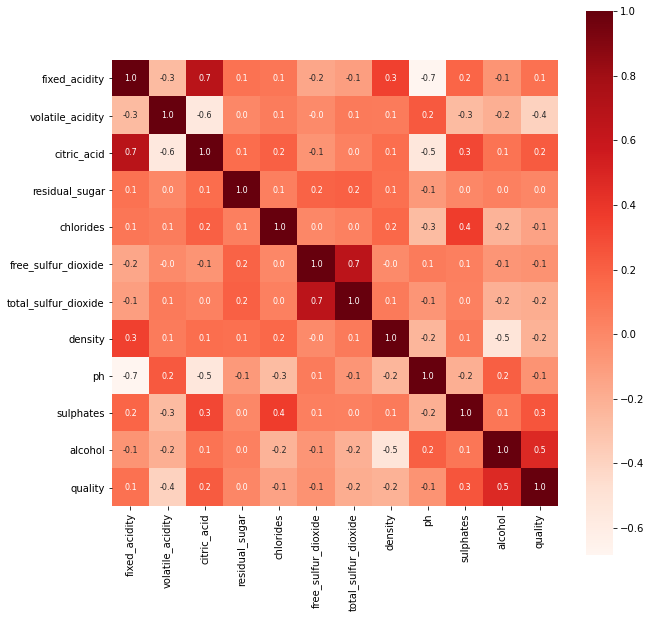

In [15]:
# Ploting the heatmap to understand the correlation between the columns
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(wine_corr, cbar=True, square=True, fmt = '.1f', annot=True, annot_kws={'size':8}, cmap = 'Reds')

**Observations:**
- Darker the color, higher is the correlation of the column with the quality
- The dark color represents the positive correlation, i.e., they are directly proportinal 
- The light color represents the negative correlation, i.e., they are inversely proportinal
- Alcohol and sulphates have positive correlation to quality
- Volatile acidity is  negatively correlated to quality
- Citric acidity has positive correlation to quality
- It looks like fixed acidity has no impact on the  quality of the wine
- Total sulphur dioxide has negative correlation to the quality
- Residual sugar are almost the same for different wines



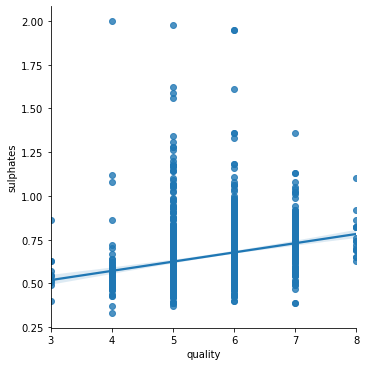

In [16]:
sns.lmplot(x="quality", y="sulphates", data=df_joined)

- **Sulphates (positive correlation): wine quality gets better when the sulphates are more**

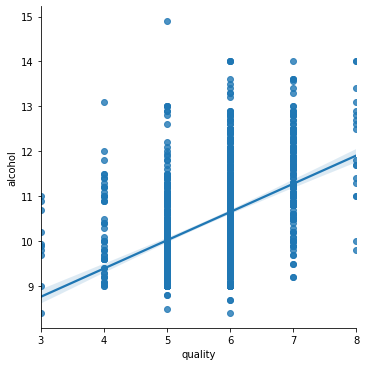

In [17]:
sns.lmplot(x="quality", y="alcohol", data=df_joined)

- **Alcohol (positive correlation): wine quality is better when alcohol is high**

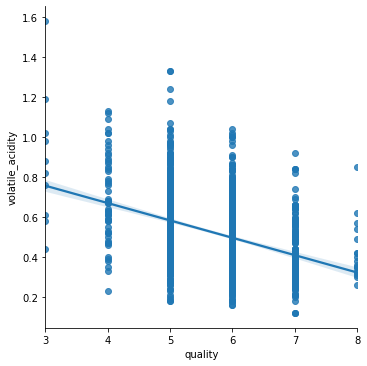

In [18]:
sns.lmplot(x="quality", y="volatile_acidity", data=df_joined)

- **Higher the volatile acidity, lower the quality**

<AxesSubplot:xlabel='quality', ylabel='chlorides'>

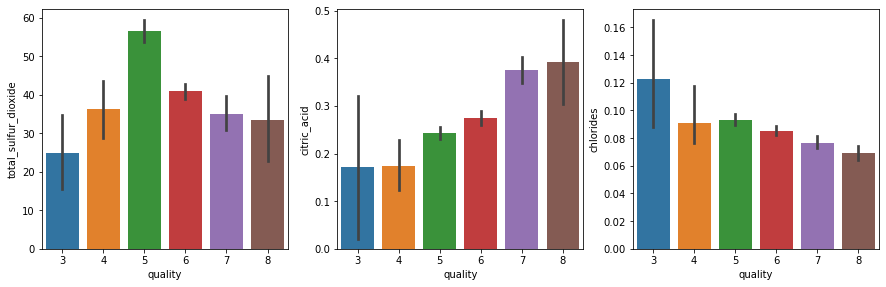

In [19]:
plt.figure(figsize=(15, 15))

plt.subplot(3,3,1)
sns.barplot(x = 'quality', y = 'total_sulfur_dioxide', data = df_joined)

plt.subplot(3,3,2)
sns.barplot(x = 'quality', y = 'citric_acid', data = df_joined)

plt.subplot(3,3,3)
sns.barplot(x = 'quality', y = 'chlorides', data = df_joined)

**Observation:**

- Total_sulfur_dioxide and quality of the wine are inverserly proportional. When the total_sulfur_dioxide is high, wine quality   is low
- If the content of citric acid is more, wine quality is better. So, citric acid is directly proportinal to quality
- Chlorides is inversely proportional to wine quality. When it's high, the quality is low

# Data Preprocessing

In [20]:
# Separate the data and label
X = df_joined.drop(['quality','description'],axis=1)
print(X)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9       0.08   
1               7.8              0.88         0.00             2.6       0.10   
2               7.8              0.76         0.04             2.3       0.09   
3              11.2              0.28         0.56             1.9       0.08   
4               7.4              0.70         0.00             1.9       0.08   
...             ...               ...          ...             ...        ...   
1594            6.2              0.60         0.08             2.0       0.09   
1595            5.9              0.55         0.10             2.2       0.06   
1596            6.3              0.51         0.13             2.3       0.08   
1597            5.9              0.65         0.12             2.0       0.08   
1598            6.0              0.31         0.47             3.6       0.07   

      free_sulfur_dioxide  

### Label Encoding

In [21]:
y = df_joined['description'].apply(lambda value:1 if value=='Good' else 0)
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
1594    0
1595    0
1596    0
1597    0
1598    0
Name: description, Length: 1599, dtype: int64


**1 is "good" quality wine and 0 is "not good" quality wine**

### Training and Spliting Data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state = 78)


In [23]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1279, 11)
(320, 11)
(1279,)
(320,)


In [24]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Train the ML Model with Standard Decision Tree

In [25]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [26]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [27]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [28]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


Predicted 0  Predicted 1
Actual 0          261            9
Actual 1           16           34

Accuracy Score : 0.921875
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       270
           1       0.79      0.68      0.73        50

    accuracy                           0.92       320
   macro avg       0.87      0.82      0.84       320
weighted avg       0.92      0.92      0.92       320



## Visualizng the Decision Tree

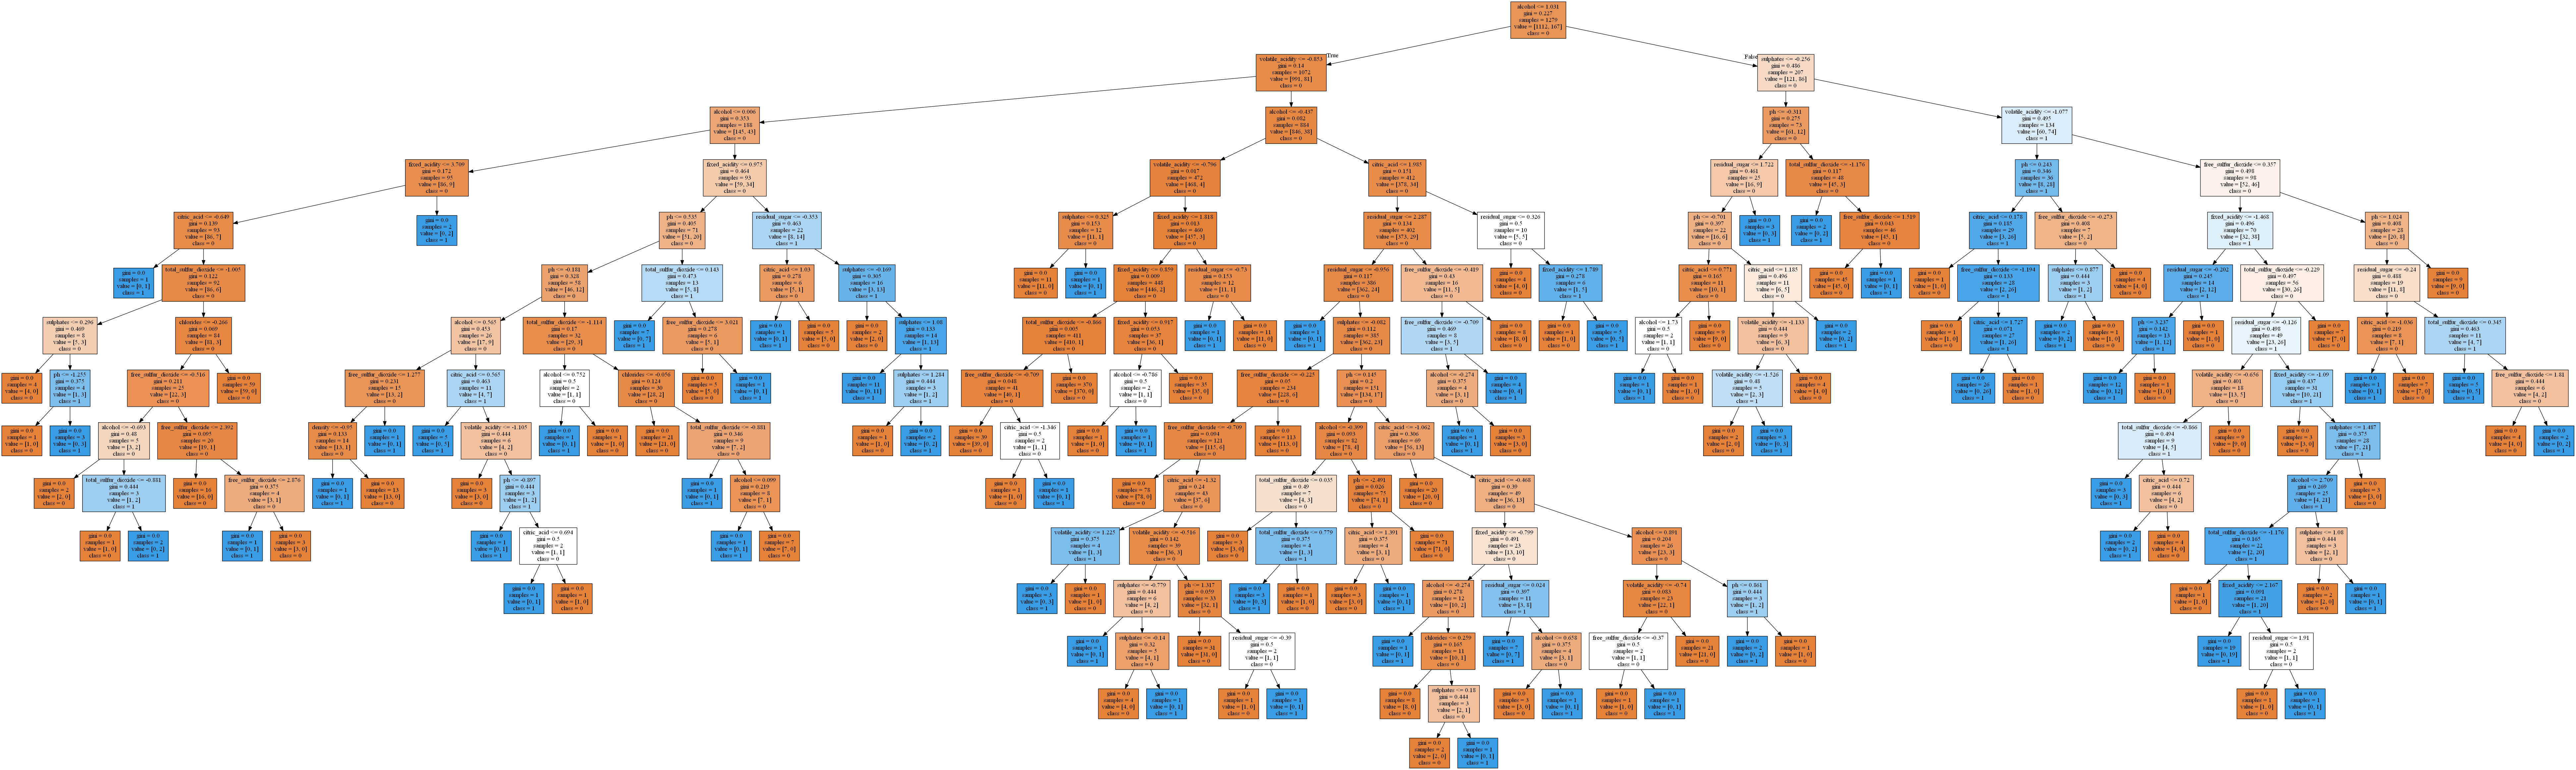

In [29]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, 
    out_file=None, 
    feature_names=X.columns, 
    class_names=["0", "1"],
    filled=True
)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
# Show graph
Image(graph.create_png())

In [30]:
 # Saving the tree as PDF
file_path = Path("Resources/wine_tree.pdf")
graph.write_pdf(file_path)
# Saving the tree as PNG
file_path = Path("Resources/wine_tree.png")
graph.write_png(file_path)

True

### Train the ML Model with Random Forest Classifier

In [31]:
## Assigning the RandomForestClassifier to a variable
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

In [32]:
## Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)


### Evaluate the model using accuracy score value

In [33]:
## Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [34]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
acc_score

0.925

**Observation:**
- The accuracy score is 93, which means that out of 100 predictions, our model can correctly predict for 93 values

In [35]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)
cm

array([[269,   1],
       [ 23,  27]], dtype=int64)

In [36]:
# Creating a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

Predicted 0  Predicted 1
Actual 0          269            1
Actual 1           23           27

**Observations:**
- True positives: 278
- False positives: 16
- False negatives: 5
- True negatives: 21

In [37]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


Predicted 0  Predicted 1
Actual 0          269            1
Actual 1           23           27

Accuracy Score : 0.925
Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       270
           1       0.96      0.54      0.69        50

    accuracy                           0.93       320
   macro avg       0.94      0.77      0.82       320
weighted avg       0.93      0.93      0.92       320



In [38]:
# Calculating the feature importance
importances = rf_model.feature_importances_
importances

array([0.08187926, 0.12127719, 0.09321721, 0.07999088, 0.05213921,
       0.07117224, 0.09676524, 0.01714761, 0.07489897, 0.13066506,
       0.18084713])

In [39]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.180847131495865, 'alcohol'),
 (0.13066505621413746, 'sulphates'),
 (0.1212771880348002, 'volatile_acidity'),
 (0.09676523612613973, 'total_sulfur_dioxide'),
 (0.09321720874901661, 'citric_acid'),
 (0.0818792616241614, 'fixed_acidity'),
 (0.07999088187958542, 'residual_sugar'),
 (0.07489897147252006, 'ph'),
 (0.07117224384129824, 'free_sulfur_dioxide'),
 (0.052139211075026504, 'chlorides'),
 (0.017147609487449457, 'density')]

**Observation:**
- Alcohol, sulphase and volatile acidity are the more important features for the model